## 单股单维度训练（五个代码块依次运行）

1.准备数据：这里以‘AAPL’这只股为例

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('all_stocks_5yr.csv')

# Prepare data
def prepare_data(seq_length=60):
    stock_data = data[data['Name'] == 'AAPL']
    stock_data = stock_data[['date', 'close']]
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data = stock_data.sort_values('date')
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data['close'] = scaler.fit_transform(stock_data[['close']])
    
    def create_sequences(data, seq_length):
        xs = []
        ys = []
        for i in range(len(data) - seq_length):
            x = data[i:i + seq_length]
            y = data[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    X, y = create_sequences(stock_data['close'].values, seq_length)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float().unsqueeze(-1)
    y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
    X_test = torch.from_numpy(X_test).float().unsqueeze(-1)
    y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
    
    return X_train, y_train, X_test, y_test, scaler

2.定义LSTM结构

In [7]:
import torch
import torch.nn as nn

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size)
        self.bf = nn.Parameter(torch.zeros(hidden_size))
        
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size)
        self.bi = nn.Parameter(torch.zeros(hidden_size))
        
        self.Wxc = nn.Linear(input_size, hidden_size)
        self.Whc = nn.Linear(hidden_size, hidden_size)
        self.bc = nn.Parameter(torch.zeros(hidden_size))
        
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size)
        self.bo = nn.Parameter(torch.zeros(hidden_size))
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_t) + self.bf)
            
            i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_t) + self.bi)
            c_tilde_t = torch.tanh(self.Wxc(x_t) + self.Whc(h_t) + self.bc)
            
            c_t = f_t * c_t + i_t * c_tilde_t
            
            o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_t) + self.bo)
            
            h_t = o_t * torch.tanh(c_t)
            
            h_t = self.dropout(h_t)
        
        out = self.fc(h_t)
        
        return out

3.定义训练函数和评价函数

In [8]:

def train_model(model, X_train, y_train, num_epochs=300, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model


def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test)
    return predictions, mse.item()

4.定义反向转换和可视化过程

In [9]:

def inverse_transform(scaler, predictions, y_test):
    predictions = scaler.inverse_transform(predictions.detach().cpu().numpy())
    y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())
    return predictions, y_test


def plot_results(train_results, test_results, stock_name):
    plt.figure(figsize=(14, 7))
    plt.plot(train_results['True'], label='Train True')
    plt.plot(train_results['Predicted'], label='Train Predicted')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['True'], label='Test True')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['Predicted'], label='Test Predicted')
    plt.legend()
    plt.title(f'Stock Prediction for {stock_name} by LSTM')
    plt.show()

5.训练和可视化

Epoch [10/300], Loss: 0.0242
Epoch [20/300], Loss: 0.0199
Epoch [30/300], Loss: 0.0143
Epoch [40/300], Loss: 0.0099
Epoch [50/300], Loss: 0.0095
Epoch [60/300], Loss: 0.0089
Epoch [70/300], Loss: 0.0079
Epoch [80/300], Loss: 0.0071
Epoch [90/300], Loss: 0.0070
Epoch [100/300], Loss: 0.0061
Epoch [110/300], Loss: 0.0060
Epoch [120/300], Loss: 0.0060
Epoch [130/300], Loss: 0.0049
Epoch [140/300], Loss: 0.0049
Epoch [150/300], Loss: 0.0045
Epoch [160/300], Loss: 0.0044
Epoch [170/300], Loss: 0.0038
Epoch [180/300], Loss: 0.0036
Epoch [190/300], Loss: 0.0034
Epoch [200/300], Loss: 0.0035
Epoch [210/300], Loss: 0.0032
Epoch [220/300], Loss: 0.0032
Epoch [230/300], Loss: 0.0030
Epoch [240/300], Loss: 0.0029
Epoch [250/300], Loss: 0.0028
Epoch [260/300], Loss: 0.0026
Epoch [270/300], Loss: 0.0027
Epoch [280/300], Loss: 0.0025
Epoch [290/300], Loss: 0.0025
Epoch [300/300], Loss: 0.0024
AAPL Test MSE: 0.0067


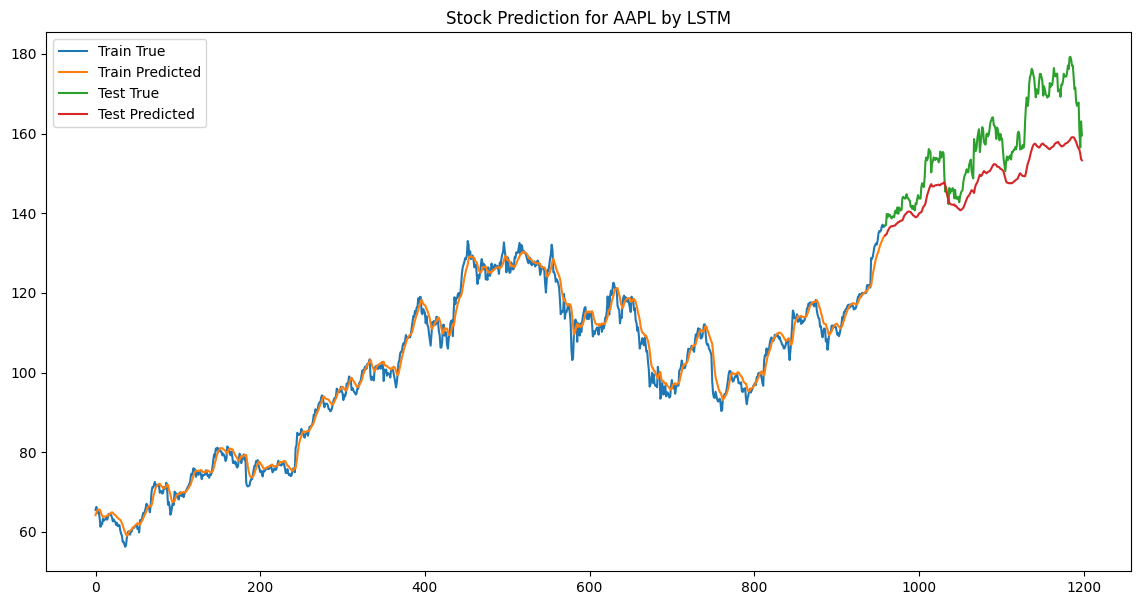

In [10]:

X_train, y_train, X_test, y_test, scaler = prepare_data()


lstm_model = CustomLSTM(input_size=1, hidden_size=50, output_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

lstm_model = train_model(lstm_model, X_train, y_train)


predictions, mse = evaluate_model(lstm_model, X_test, y_test)
print(f'AAPL Test MSE: {mse:.4f}')


train_predictions, y_train = inverse_transform(scaler, lstm_model(X_train), y_train)
test_predictions, y_test = inverse_transform(scaler, predictions, y_test)


train_results = pd.DataFrame(data={'True': y_train.flatten(), 'Predicted': train_predictions.flatten()})
test_results = pd.DataFrame(data={'True': y_test.flatten(), 'Predicted': test_predictions.flatten()})


plot_results(train_results, test_results, 'AAPL')

分析：测试集MSE偏高，说明预测精度可以通过增加数据量等方式进一步提高，从股价预测图像上来看，训练集拟合较好，但是测试集拟合较差，训练集MSE显著低于测试集MSE，需要增加数据量和采取防止过拟合方法进行训练。

# 多股单维数据训练

改进：增加数据量，将更多股票引入作为数据，增强模型泛化能力。

Epoch [10/300], Loss: 0.0698
Epoch [20/300], Loss: 0.0445
Epoch [30/300], Loss: 0.0205
Epoch [40/300], Loss: 0.0088
Epoch [50/300], Loss: 0.0099
Epoch [60/300], Loss: 0.0075
Epoch [70/300], Loss: 0.0075
Epoch [80/300], Loss: 0.0067
Epoch [90/300], Loss: 0.0060
Epoch [100/300], Loss: 0.0056
Epoch [110/300], Loss: 0.0054
Epoch [120/300], Loss: 0.0049
Epoch [130/300], Loss: 0.0045
Epoch [140/300], Loss: 0.0042
Epoch [150/300], Loss: 0.0038
Epoch [160/300], Loss: 0.0038
Epoch [170/300], Loss: 0.0036
Epoch [180/300], Loss: 0.0034
Epoch [190/300], Loss: 0.0032
Epoch [200/300], Loss: 0.0030
Epoch [210/300], Loss: 0.0031
Epoch [220/300], Loss: 0.0029
Epoch [230/300], Loss: 0.0029
Epoch [240/300], Loss: 0.0028
Epoch [250/300], Loss: 0.0026
Epoch [260/300], Loss: 0.0025
Epoch [270/300], Loss: 0.0025
Epoch [280/300], Loss: 0.0026
Epoch [290/300], Loss: 0.0024
Epoch [300/300], Loss: 0.0026
Test MSE: 0.0003


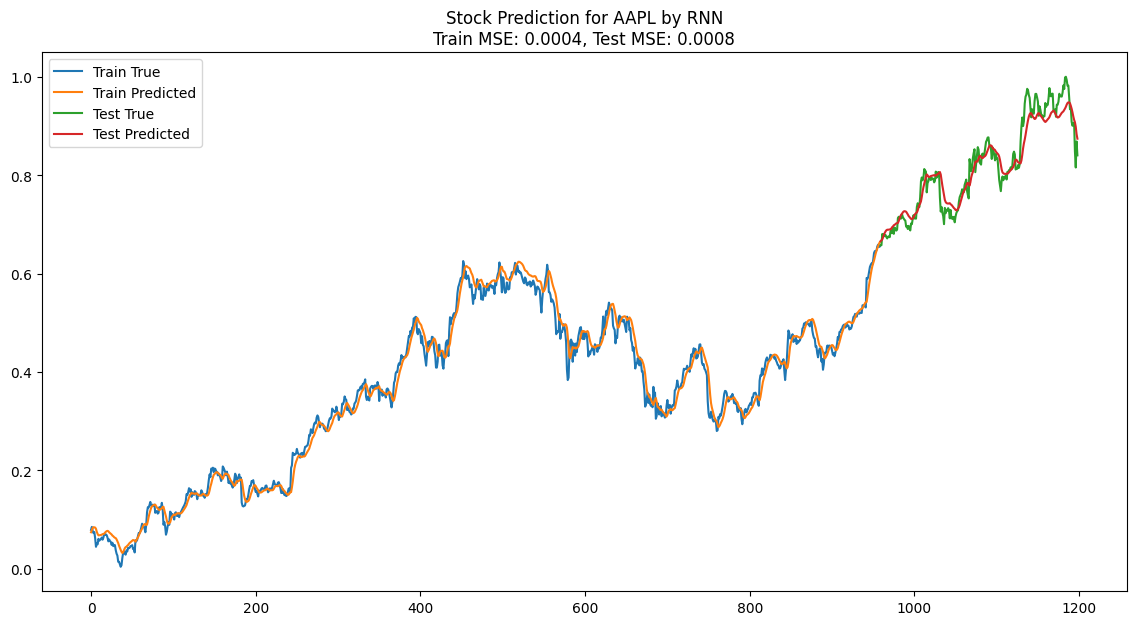

AAPL Train MSE: 0.0004
AAPL Test MSE: 0.0008


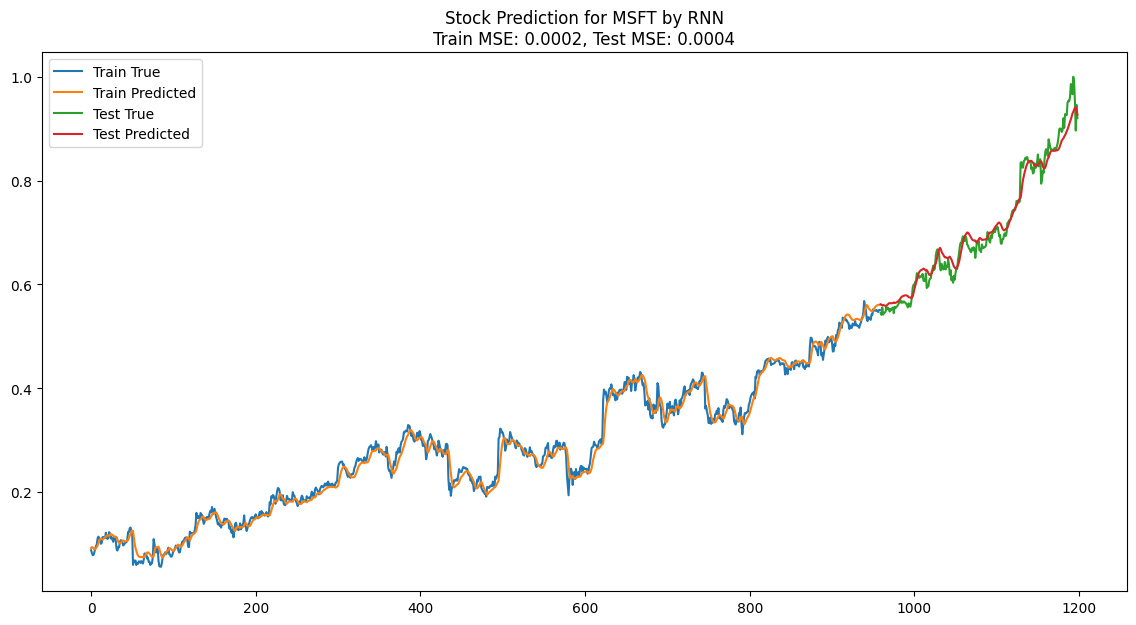

MSFT Train MSE: 0.0002
MSFT Test MSE: 0.0004


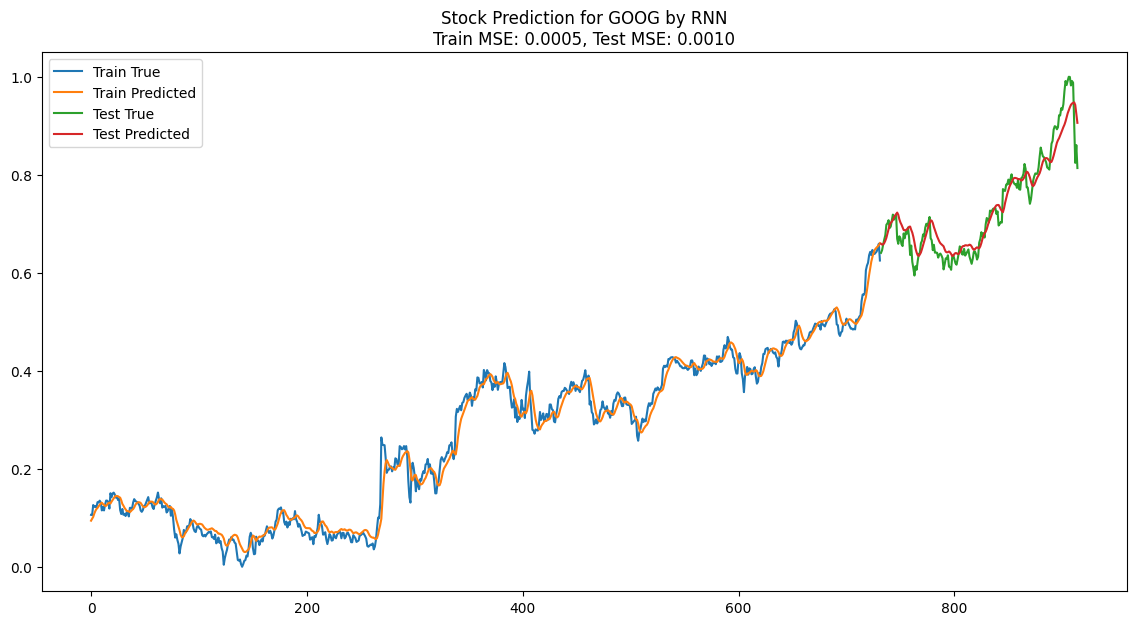

GOOG Train MSE: 0.0005
GOOG Test MSE: 0.0010


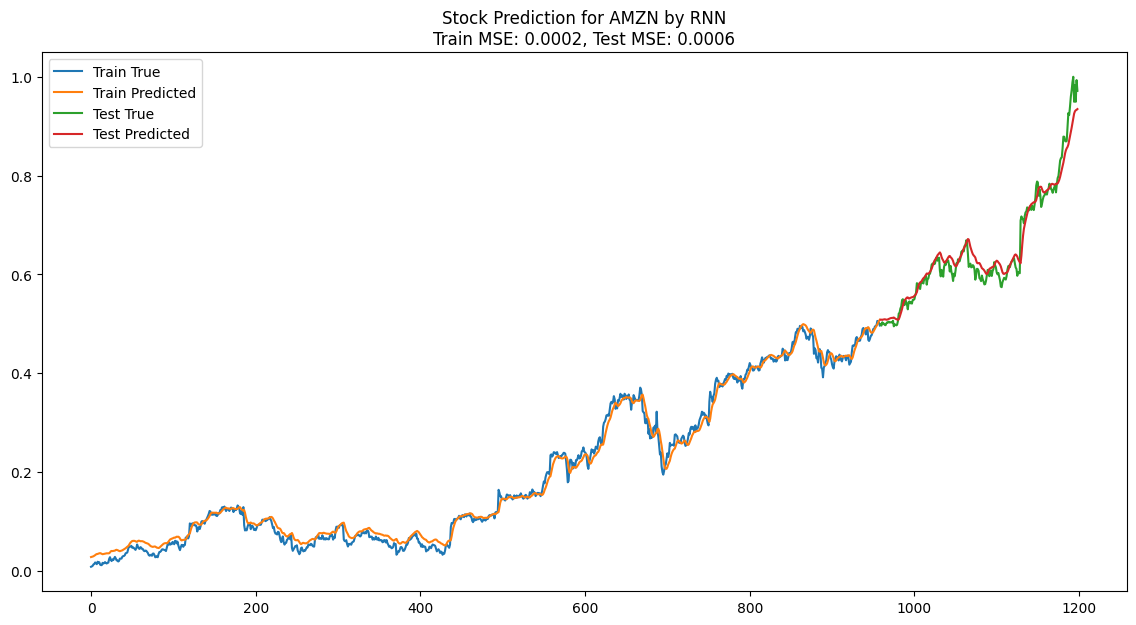

AMZN Train MSE: 0.0002
AMZN Test MSE: 0.0006


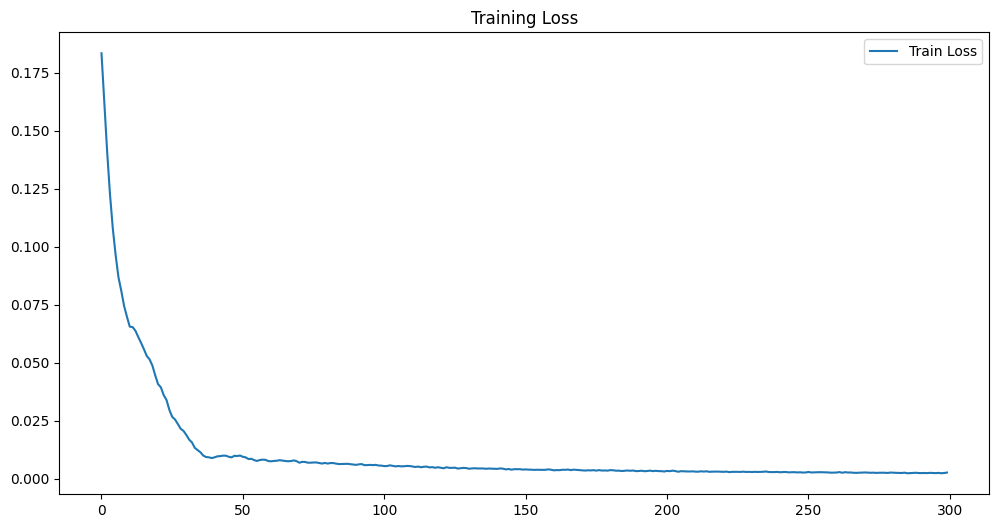

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


data = pd.read_csv('all_stocks_5yr.csv')


def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


def prepare_data(stock_names, seq_length=60):
    sequences = []
    scalers = {}
    for stock in stock_names:
        stock_data = data[data['Name'] == stock]
        stock_data = stock_data[['date', 'close']]
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        stock_data = stock_data.sort_values('date')
        scaler = MinMaxScaler(feature_range=(0, 1))
        stock_data['close'] = scaler.fit_transform(stock_data[['close']])
        stock_sequences, stock_labels = create_sequences(stock_data['close'].values, seq_length)
        sequences.extend(list(zip(stock_sequences, stock_labels)))
        scalers[stock] = scaler
    
    X, y = zip(*sequences)
    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float().unsqueeze(-1)
    y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
    X_test = torch.from_numpy(X_test).float().unsqueeze(-1)
    y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
    return X_train, y_train, X_test, y_test, scalers


def prepare_single_stock_data(stock_name, seq_length=60):
    stock_data = data[data['Name'] == stock_name]
    stock_data = stock_data[['date', 'close']]
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data = stock_data.sort_values('date')
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data['close'] = scaler.fit_transform(stock_data[['close']])
    X, y = create_sequences(stock_data['close'].values, seq_length)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float().unsqueeze(-1)
    y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
    X_test = torch.from_numpy(X_test).float().unsqueeze(-1)
    y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
    return X_train, y_train, X_test, y_test, scaler

#LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size)
        self.bf = nn.Parameter(torch.zeros(hidden_size))
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size)
        self.bi = nn.Parameter(torch.zeros(hidden_size))
        self.Wxc = nn.Linear(input_size, hidden_size)
        self.Whc = nn.Linear(hidden_size, hidden_size)
        self.bc = nn.Parameter(torch.zeros(hidden_size))
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size)
        self.bo = nn.Parameter(torch.zeros(hidden_size))
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        for t in range(seq_len):
            x_t = x[:, t, :]
            f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_t) + self.bf)
            i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_t) + self.bi)
            c_tilde_t = torch.tanh(self.Wxc(x_t) + self.Whc(h_t) + self.bc)
            c_t = f_t * c_t + i_t * c_tilde_t
            o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_t) + self.bo)
            h_t = o_t * torch.tanh(c_t)
            h_t = self.dropout(h_t)
        out = self.fc(h_t)
        return out

# Train the model
def train_model(model, X_train, y_train, num_epochs=300, learning_rate=0.001, weight_decay=1e-5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model, loss_history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test)
    return predictions, mse.item()

# Inverse transform predictions and true values
def inverse_transform(scaler, data):
    data = scaler.inverse_transform(data.detach().cpu().numpy())
    return data

# Plot the results
def plot_results(train_results, test_results, stock_name,train_mse,test_mse):
    plt.figure(figsize=(14, 7))
    plt.plot(train_results['True'], label='Train True')
    plt.plot(train_results['Predicted'], label='Train Predicted')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['True'], label='Test True')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['Predicted'], label='Test Predicted')
    plt.legend()
    plt.title(f'Stock Prediction for {stock_name} by RNN\nTrain MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
    plt.show()

# Evaluate and plot function
def evaluate_and_plot(stock_name, model, seq_length=60):
    X_train_stock, y_train_stock, X_test_stock, y_test_stock, scaler_stock = prepare_single_stock_data(stock_name, seq_length)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train_stock, y_train_stock = X_train_stock.to(device), y_train_stock.to(device)
    X_test_stock, y_test_stock = X_test_stock.to(device), y_test_stock.to(device)

    model.eval()
    with torch.no_grad():
        train_predictions_stock = model(X_train_stock)
        test_predictions_stock = model(X_test_stock)
    
    train_results_stock = pd.DataFrame(data={'True': y_train_stock.cpu().numpy().flatten(), 'Predicted': train_predictions_stock.cpu().numpy().flatten()})
    test_results_stock = pd.DataFrame(data={'True': y_test_stock.cpu().numpy().flatten(), 'Predicted': test_predictions_stock.cpu().numpy().flatten()})


    train_mse_stock = np.mean((train_results_stock['True'] - train_results_stock['Predicted'])**2)
    test_mse_stock = np.mean((test_results_stock['True'] - test_results_stock['Predicted'])**2)

    plot_results(train_results_stock, test_results_stock, stock_name,train_mse_stock,test_mse_stock)

    print(f'{stock_name} Train MSE: {train_mse_stock:.4f}')
    print(f'{stock_name} Test MSE: {test_mse_stock:.4f}')

stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
X_train, y_train, X_test, y_test, scaler = prepare_data(stocks)

lstm_model = CustomLSTM(input_size=1, hidden_size=50, output_size=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

lstm_model, train_loss_history = train_model(lstm_model, X_train, y_train)

predictions, mse = evaluate_model(lstm_model, X_test, y_test)
print(f'Test MSE: {mse:.4f}')

evaluate_and_plot('AAPL', lstm_model)
evaluate_and_plot('MSFT', lstm_model)
evaluate_and_plot('GOOG', lstm_model)
evaluate_and_plot('AMZN', lstm_model)

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# 单股多维度数据训练

改进2.1：对每只股票分别预测模型，并采用多维度数据进行训练：

Epoch [10/200], Loss: 0.0211
Epoch [20/200], Loss: 0.0211
Epoch [30/200], Loss: 0.0098
Epoch [40/200], Loss: 0.0078
Epoch [50/200], Loss: 0.0060
Epoch [60/200], Loss: 0.0046
Epoch [70/200], Loss: 0.0050
Epoch [80/200], Loss: 0.0046
Epoch [90/200], Loss: 0.0043
Epoch [100/200], Loss: 0.0046
Epoch [110/200], Loss: 0.0037
Epoch [120/200], Loss: 0.0041
Epoch [130/200], Loss: 0.0043
Epoch [140/200], Loss: 0.0037
Epoch [150/200], Loss: 0.0036
Epoch [160/200], Loss: 0.0033
Epoch [170/200], Loss: 0.0032
Epoch [180/200], Loss: 0.0033
Epoch [190/200], Loss: 0.0030
Epoch [200/200], Loss: 0.0032
AAPL Test MSE: 0.0051


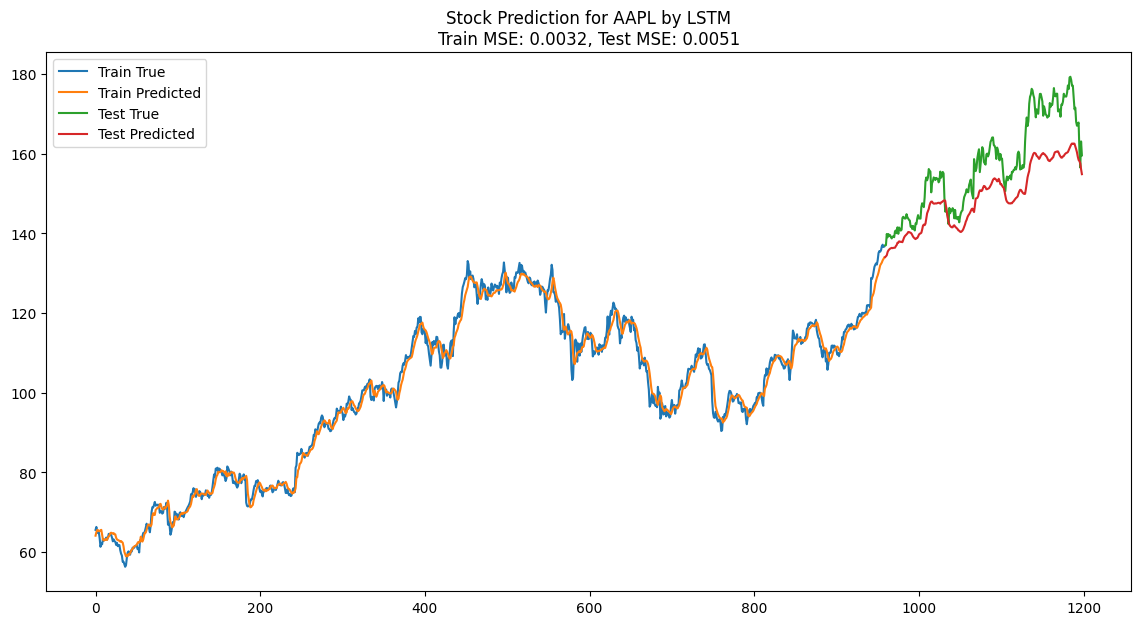

Epoch [10/200], Loss: 0.0080
Epoch [20/200], Loss: 0.0101
Epoch [30/200], Loss: 0.0063
Epoch [40/200], Loss: 0.0042
Epoch [50/200], Loss: 0.0029
Epoch [60/200], Loss: 0.0026
Epoch [70/200], Loss: 0.0025
Epoch [80/200], Loss: 0.0023
Epoch [90/200], Loss: 0.0023
Epoch [100/200], Loss: 0.0022
Epoch [110/200], Loss: 0.0020
Epoch [120/200], Loss: 0.0021
Epoch [130/200], Loss: 0.0018
Epoch [140/200], Loss: 0.0019
Epoch [150/200], Loss: 0.0017
Epoch [160/200], Loss: 0.0018
Epoch [170/200], Loss: 0.0016
Epoch [180/200], Loss: 0.0016
Epoch [190/200], Loss: 0.0015
Epoch [200/200], Loss: 0.0016
MSFT Test MSE: 0.0035


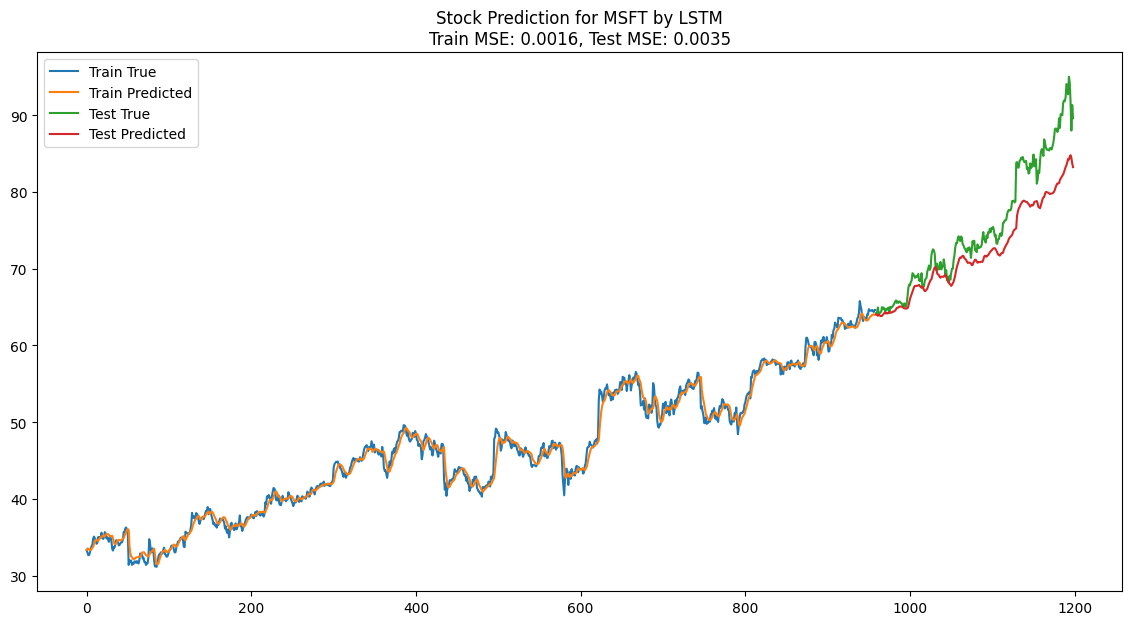

Epoch [10/200], Loss: 0.0165
Epoch [20/200], Loss: 0.0066
Epoch [30/200], Loss: 0.0023
Epoch [40/200], Loss: 0.0021
Epoch [50/200], Loss: 0.0019
Epoch [60/200], Loss: 0.0017
Epoch [70/200], Loss: 0.0016
Epoch [80/200], Loss: 0.0016
Epoch [90/200], Loss: 0.0014
Epoch [100/200], Loss: 0.0016
Epoch [110/200], Loss: 0.0014
Epoch [120/200], Loss: 0.0013
Epoch [130/200], Loss: 0.0013
Epoch [140/200], Loss: 0.0013
Epoch [150/200], Loss: 0.0012
Epoch [160/200], Loss: 0.0011
Epoch [170/200], Loss: 0.0012
Epoch [180/200], Loss: 0.0010
Epoch [190/200], Loss: 0.0011
Epoch [200/200], Loss: 0.0010
GOOG Test MSE: 0.0033


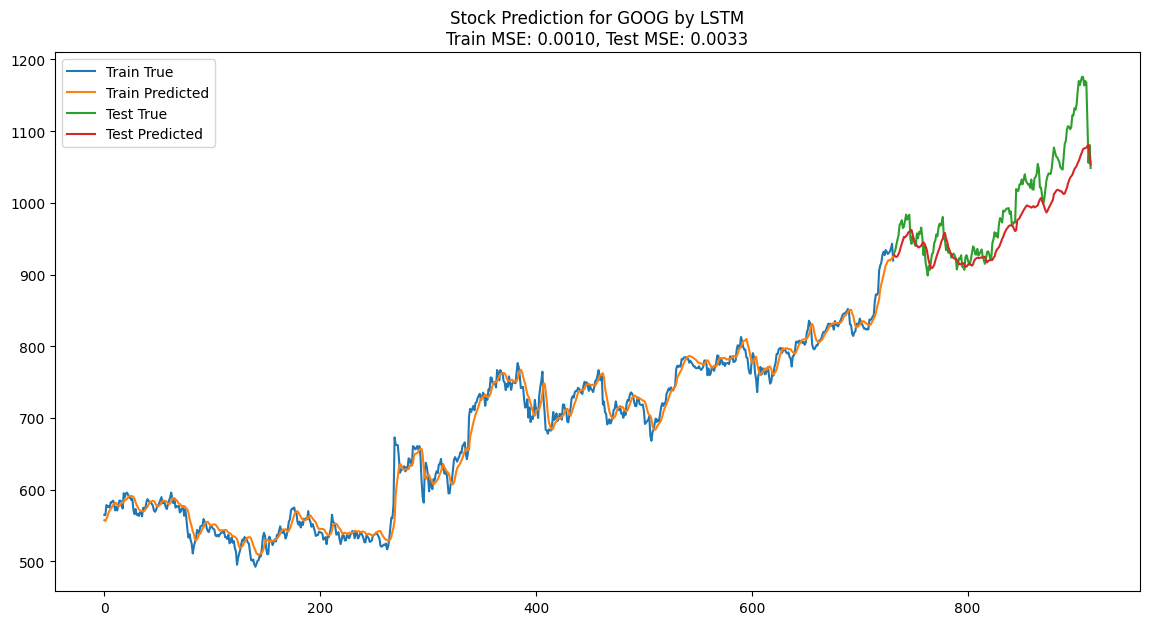

Epoch [10/200], Loss: 0.0127
Epoch [20/200], Loss: 0.0027
Epoch [30/200], Loss: 0.0025
Epoch [40/200], Loss: 0.0015
Epoch [50/200], Loss: 0.0013
Epoch [60/200], Loss: 0.0011
Epoch [70/200], Loss: 0.0008
Epoch [80/200], Loss: 0.0009
Epoch [90/200], Loss: 0.0009
Epoch [100/200], Loss: 0.0008
Epoch [110/200], Loss: 0.0007
Epoch [120/200], Loss: 0.0007
Epoch [130/200], Loss: 0.0007
Epoch [140/200], Loss: 0.0006
Epoch [150/200], Loss: 0.0006
Epoch [160/200], Loss: 0.0005
Epoch [170/200], Loss: 0.0006
Epoch [180/200], Loss: 0.0005
Epoch [190/200], Loss: 0.0005
Epoch [200/200], Loss: 0.0005
AMZN Test MSE: 0.0051


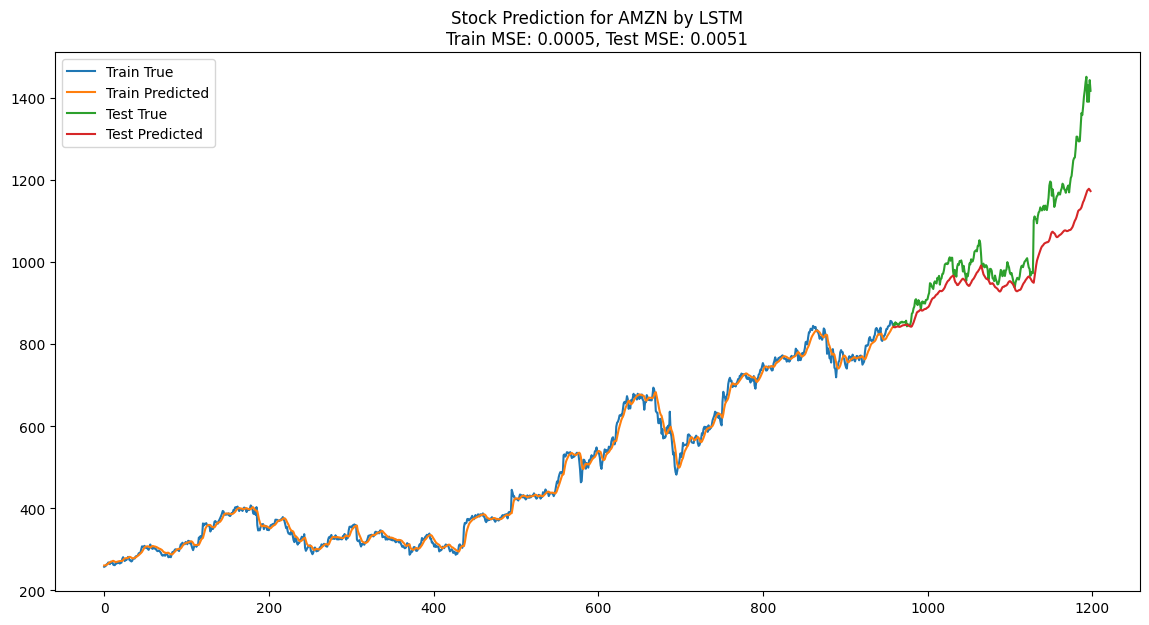

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

data = pd.read_csv('all_stocks_5yr.csv')

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def prepare_data(stock_name, seq_length=60):
    stock_data = data[data['Name'] == stock_name]
    stock_data = stock_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data = stock_data.sort_values('date')
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(stock_data[['open', 'high', 'low', 'close', 'volume']])
    X, y = create_sequences(stock_data[['open', 'high', 'low', 'close', 'volume']].values, seq_length)
    
    if len(X) == 0 or len(y) == 0:
        raise ValueError(f"Not enough data to create sequences for {stock_name} with seq_length={seq_length}")
    
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()[:, 3].unsqueeze(-1)  # 只预测收盘价
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()[:, 3].unsqueeze(-1)  # 只预测收盘价
    return X_train, y_train, X_test, y_test, scaler

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size)
        self.bf = nn.Parameter(torch.zeros(hidden_size))
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size)
        self.bi = nn.Parameter(torch.zeros(hidden_size))
        self.Wxc = nn.Linear(input_size, hidden_size)
        self.Whc = nn.Linear(hidden_size, hidden_size)
        self.bc = nn.Parameter(torch.zeros(hidden_size))
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size)
        self.bo = nn.Parameter(torch.zeros(hidden_size))
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        for t in range(seq_len):
            x_t = x[:, t, :]
            f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_t) + self.bf)
            i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_t) + self.bi)
            c_tilde_t = torch.tanh(self.Wxc(x_t) + self.Whc(h_t) + self.bc)
            c_t = f_t * c_t + i_t * c_tilde_t
            o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_t) + self.bo)
            h_t = o_t * torch.tanh(c_t)
            h_t = self.dropout(h_t)
        out = self.fc(h_t)
        return out

def train_model(model, X_train, y_train, num_epochs=200, learning_rate=0.001, weight_decay=1e-5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model, loss_history

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test)
    return predictions, mse.item()

def inverse_transform(scaler, predictions, y_test):
    dummy_input = np.zeros((predictions.shape[0], 5))
    
    dummy_input[:, 3] = predictions.detach().cpu().numpy().flatten()
    
    dummy_output = scaler.inverse_transform(dummy_input)
    
    predictions = dummy_output[:, 3]

    dummy_input[:, 3] = y_test.detach().cpu().numpy().flatten()
    dummy_output = scaler.inverse_transform(dummy_input)
    y_test = dummy_output[:, 3]
    
    return predictions, y_test

def plot_results(train_results, test_results, stock_name, train_mse, test_mse):
    plt.figure(figsize=(14, 7))
    plt.plot(train_results['True'], label='Train True')
    plt.plot(train_results['Predicted'], label='Train Predicted')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['True'], label='Test True')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['Predicted'], label='Test Predicted')
    plt.legend()
    plt.title(f'Stock Prediction for {stock_name} by LSTM\nTrain MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
    plt.show()

def train_and_evaluate_stock(stock_name, seq_length=60):
    X_train, y_train, X_test, y_test, scaler = prepare_data(stock_name, seq_length)
    
    lstm_model = CustomLSTM(input_size=X_train.size(2), hidden_size=50, output_size=1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lstm_model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)
    
    lstm_model, train_loss_history = train_model(lstm_model, X_train, y_train)
    
    predictions, test_mse = evaluate_model(lstm_model, X_test, y_test)
    print(f'{stock_name} Test MSE: {test_mse:.4f}')
    
    train_predictions, y_train = inverse_transform(scaler, lstm_model(X_train), y_train)
    test_predictions, y_test = inverse_transform(scaler, predictions, y_test)
    
    train_mse = train_loss_history[-1]
    
    train_results = pd.DataFrame(data={'True': y_train.flatten(), 'Predicted': train_predictions.flatten()})
    test_results = pd.DataFrame(data={'True': y_test.flatten(), 'Predicted': test_predictions.flatten()})
    
    plot_results(train_results, test_results, stock_name, train_mse, test_mse)
    
    return lstm_model, train_loss_history

stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']

for stock in stocks:
    train_and_evaluate_stock(stock)

# 多股多维度数据训练

改进2.2：使用多只股票数据进行训练，并采用多维度数据

Epoch [10/400], Loss: 0.0699
Epoch [20/400], Loss: 0.0271
Epoch [30/400], Loss: 0.0109
Epoch [40/400], Loss: 0.0094
Epoch [50/400], Loss: 0.0063
Epoch [60/400], Loss: 0.0060
Epoch [70/400], Loss: 0.0055
Epoch [80/400], Loss: 0.0056
Epoch [90/400], Loss: 0.0052
Epoch [100/400], Loss: 0.0051
Epoch [110/400], Loss: 0.0048
Epoch [120/400], Loss: 0.0050
Epoch [130/400], Loss: 0.0049
Epoch [140/400], Loss: 0.0048
Epoch [150/400], Loss: 0.0045
Epoch [160/400], Loss: 0.0045
Epoch [170/400], Loss: 0.0043
Epoch [180/400], Loss: 0.0041
Epoch [190/400], Loss: 0.0041
Epoch [200/400], Loss: 0.0042
Epoch [210/400], Loss: 0.0039
Epoch [220/400], Loss: 0.0038
Epoch [230/400], Loss: 0.0038
Epoch [240/400], Loss: 0.0036
Epoch [250/400], Loss: 0.0034
Epoch [260/400], Loss: 0.0034
Epoch [270/400], Loss: 0.0034
Epoch [280/400], Loss: 0.0034
Epoch [290/400], Loss: 0.0032
Epoch [300/400], Loss: 0.0032
Epoch [310/400], Loss: 0.0030
Epoch [320/400], Loss: 0.0032
Epoch [330/400], Loss: 0.0031
Epoch [340/400], Lo

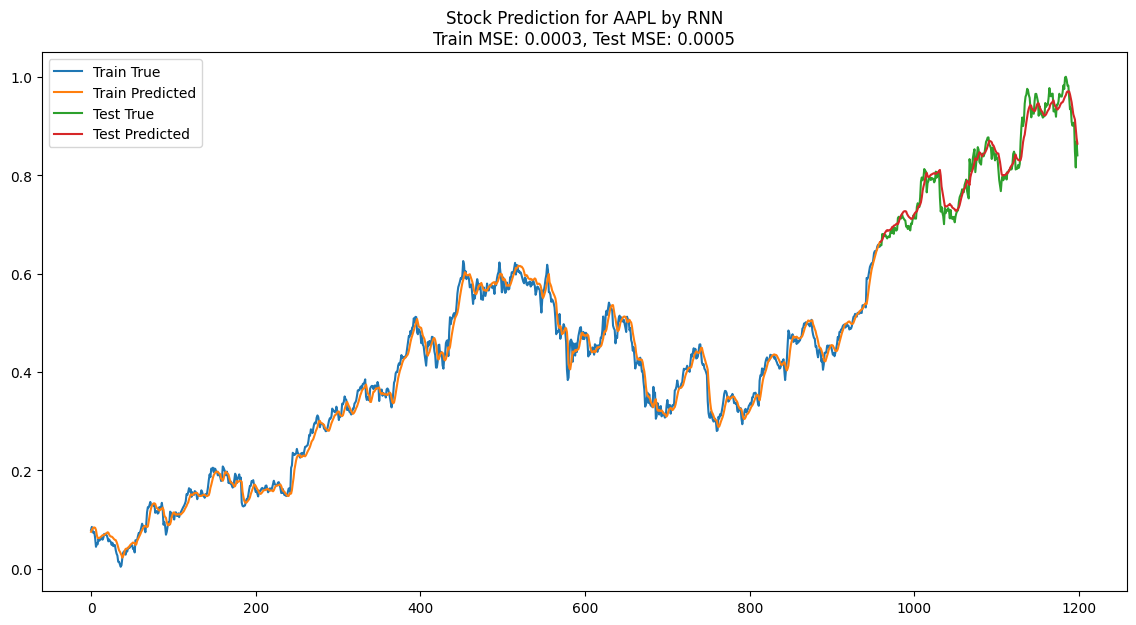

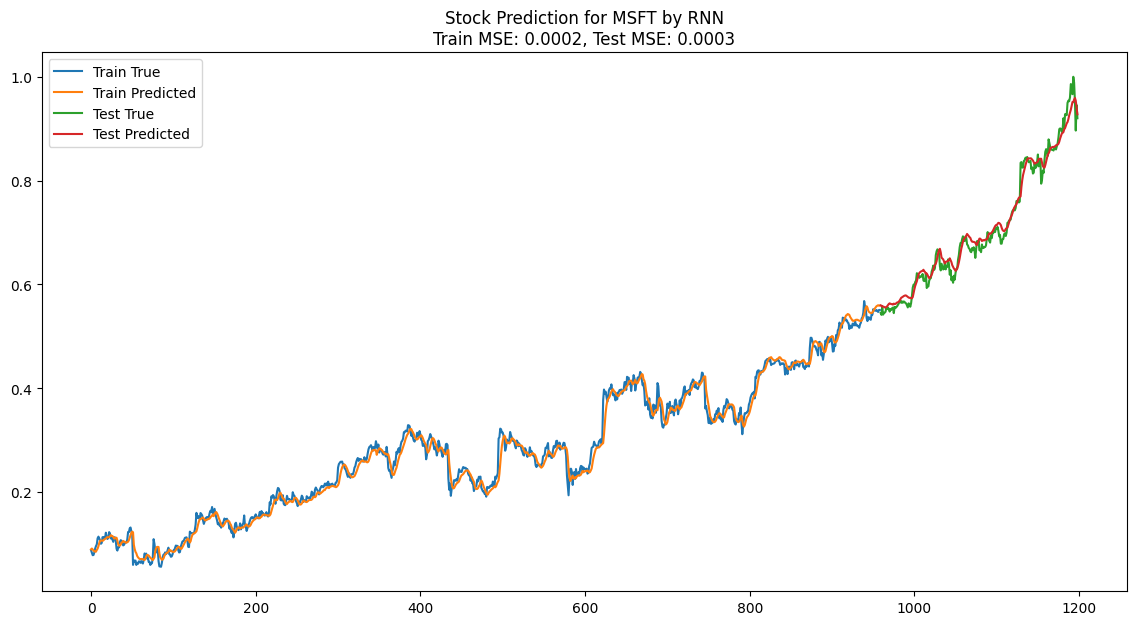

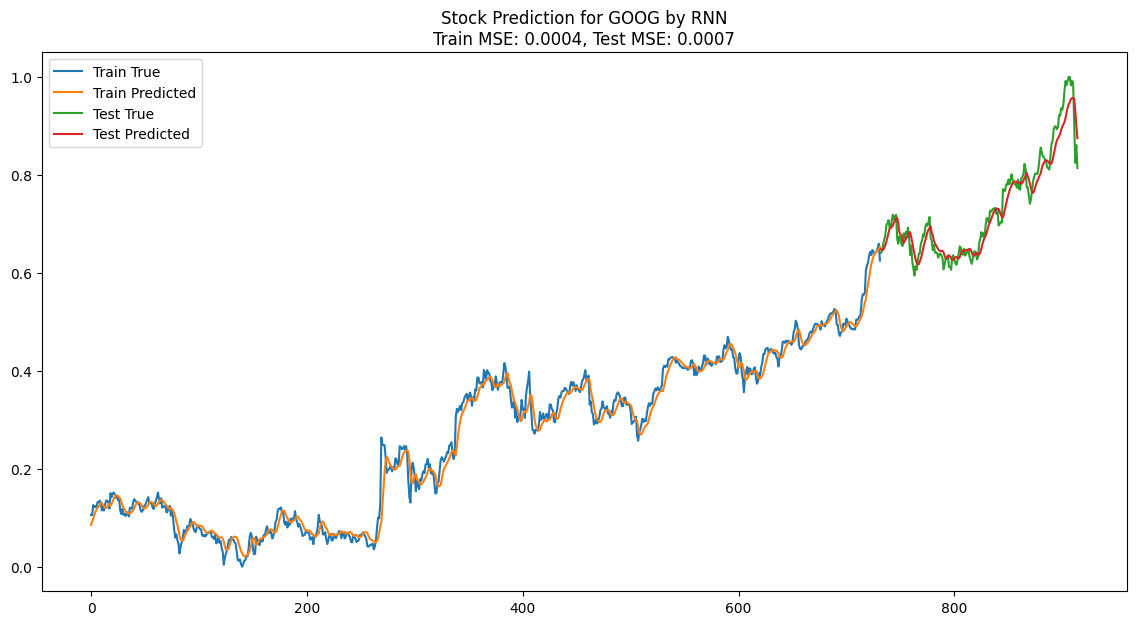

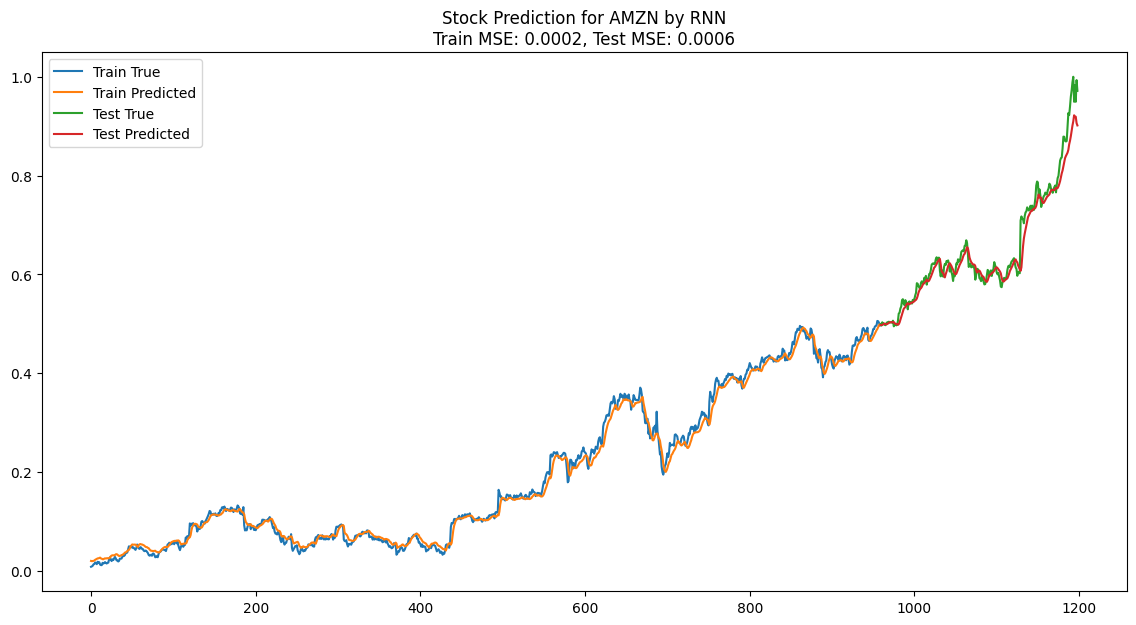

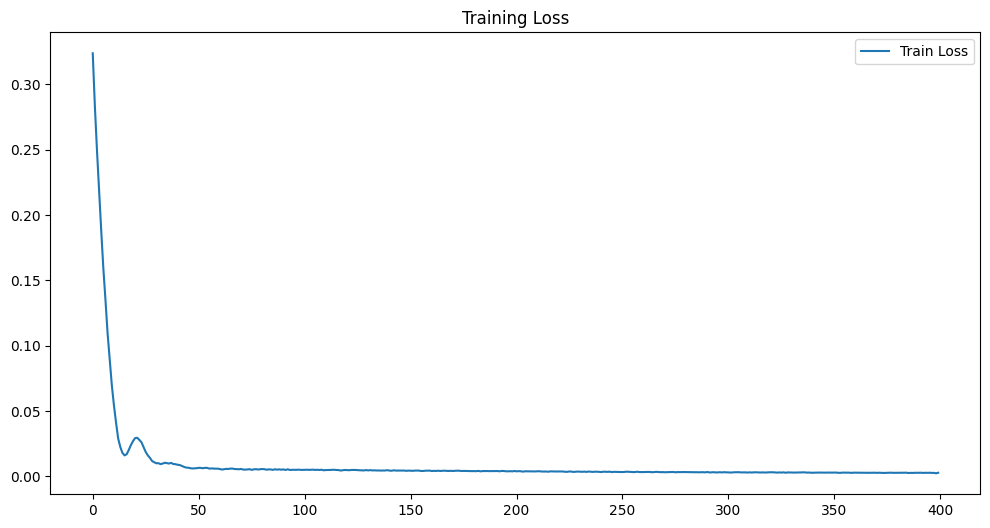

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

data = pd.read_csv('all_stocks_5yr.csv')

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length][3]  
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def prepare_data(stock_names, seq_length=60):
    sequences = []
    scalers = {}
    for stock in stock_names:
        stock_data = data[data['Name'] == stock]
        stock_data = stock_data[['date', 'open', 'high', 'low', 'close', 'volume']]
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        stock_data = stock_data.sort_values('date')
        scaler = MinMaxScaler(feature_range=(0, 1))
        stock_data[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(stock_data[['open', 'high', 'low', 'close', 'volume']])
        stock_sequences, stock_labels = create_sequences(stock_data[['open', 'high', 'low', 'close', 'volume']].values, seq_length)
        sequences.extend(list(zip(stock_sequences, stock_labels)))
        scalers[stock] = scaler
    
    X, y = zip(*sequences)
    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
    return X_train, y_train, X_test, y_test, scalers

def prepare_single_stock_data(stock_name, seq_length=60):
    stock_data = data[data['Name'] == stock_name]
    stock_data = stock_data[['date', 'open', 'high', 'low', 'close', 'volume']]
    stock_data['date'] = pd.to_datetime(stock_data['date'])
    stock_data = stock_data.sort_values('date')
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(stock_data[['open', 'high', 'low', 'close', 'volume']])
    X, y = create_sequences(stock_data[['open', 'high', 'low', 'close', 'volume']].values, seq_length)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float().unsqueeze(-1)
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float().unsqueeze(-1)
    return X_train, y_train, X_test, y_test, scaler

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size)
        self.bf = nn.Parameter(torch.zeros(hidden_size))
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size)
        self.bi = nn.Parameter(torch.zeros(hidden_size))
        self.Wxc = nn.Linear(input_size, hidden_size)
        self.Whc = nn.Linear(hidden_size, hidden_size)
        self.bc = nn.Parameter(torch.zeros(hidden_size))
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size)
        self.bo = nn.Parameter(torch.zeros(hidden_size))
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        for t in range(seq_len):
            x_t = x[:, t, :]
            f_t = torch.sigmoid(self.Wxf(x_t) + self.Whf(h_t) + self.bf)
            i_t = torch.sigmoid(self.Wxi(x_t) + self.Whi(h_t) + self.bi)
            c_tilde_t = torch.tanh(self.Wxc(x_t) + self.Whc(h_t) + self.bc)
            c_t = f_t * c_t + i_t * c_tilde_t
            o_t = torch.sigmoid(self.Wxo(x_t) + self.Who(h_t) + self.bo)
            h_t = o_t * torch.tanh(c_t)
            h_t = self.dropout(h_t)
        out = self.fc(h_t)
        return out

def train_model(model, X_train, y_train, num_epochs=400, learning_rate=0.001, weight_decay=1e-5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model, loss_history

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test)
    return predictions, mse.item()

def inverse_transform(scaler, data):
    data = scaler.inverse_transform(data.detach().cpu().numpy())
    return data

def plot_results(train_results, test_results, stock_name,train_mse,test_mse):
    plt.figure(figsize=(14, 7))
    plt.plot(train_results['True'], label='Train True')
    plt.plot(train_results['Predicted'], label='Train Predicted')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['True'], label='Test True')
    plt.plot(range(len(train_results), len(train_results) + len(test_results)), test_results['Predicted'], label='Test Predicted')
    plt.legend()
    plt.title(f'Stock Prediction for {stock_name} by RNN\nTrain MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
    plt.show()

def evaluate_and_plot(stock_name, model, seq_length=60):
    X_train_stock, y_train_stock, X_test_stock, y_test_stock, scaler_stock = prepare_single_stock_data(stock_name, seq_length)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train_stock, y_train_stock = X_train_stock.to(device), y_train_stock.to(device)
    X_test_stock, y_test_stock = X_test_stock.to(device), y_test_stock.to(device)

    model.eval()
    with torch.no_grad():
        train_predictions_stock = model(X_train_stock)
        test_predictions_stock = model(X_test_stock)
    
    train_results_stock = pd.DataFrame(data={'True': y_train_stock.cpu().numpy().flatten(), 'Predicted': train_predictions_stock.cpu().numpy().flatten()})
    test_results_stock = pd.DataFrame(data={'True': y_test_stock.cpu().numpy().flatten(), 'Predicted': test_predictions_stock.cpu().numpy().flatten()})

    train_mse_stock = np.mean((train_results_stock['True'] - train_results_stock['Predicted'])**2)
    test_mse_stock = np.mean((test_results_stock['True'] - test_results_stock['Predicted'])**2)

    plot_results(train_results_stock, test_results_stock, stock_name,train_mse_stock,test_mse_stock)


stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
X_train, y_train, X_test, y_test, scalers = prepare_data(stocks)

input_size = 5  
hidden_size = 50
output_size = 1

lstm_model = CustomLSTM(input_size, hidden_size, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

lstm_model, train_loss_history = train_model(lstm_model, X_train, y_train)

predictions, mse = evaluate_model(lstm_model, X_test, y_test)
print(f'Test MSE: {mse:.4f}')

evaluate_and_plot('AAPL', lstm_model)
evaluate_and_plot('MSFT', lstm_model)
evaluate_and_plot('GOOG', lstm_model)
evaluate_and_plot('AMZN', lstm_model)

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.legend()
plt.title('Training Loss')
plt.show()